<a href="https://colab.research.google.com/github/mariemouertani104/Building-AI-Agent/blob/main/Biulding_ai_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training finished
Evaluation results over 10 episodes
Average number of steps : 10.0
Average total reward    : 11.0


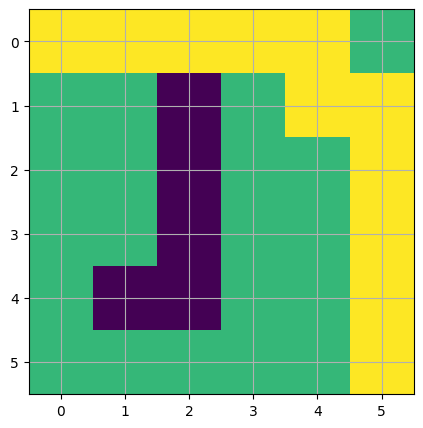

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

# -------------------------
# Environment with obstacles
# -------------------------

class GridWorld:
    def __init__(self, size=6, obstacles=None):
        self.size = size

        if obstacles is None:
            self.obstacles = [(1,2),(2,2),(3,2),(4,1),(4,2)]
        else:
            self.obstacles = obstacles

        self.reset()

    def reset(self):
        self.agent_pos = [0, 0]
        return self.get_state()

    def get_state(self):
        return self.agent_pos[0] * self.size + self.agent_pos[1]

    def is_obstacle(self, pos):
        return tuple(pos) in self.obstacles

    def step(self, action):
        # 0=up, 1=down, 2=left, 3=right

        old_pos = self.agent_pos.copy()

        if action == 0:
            new_pos = [self.agent_pos[0]-1, self.agent_pos[1]]
        elif action == 1:
            new_pos = [self.agent_pos[0]+1, self.agent_pos[1]]
        elif action == 2:
            new_pos = [self.agent_pos[0], self.agent_pos[1]-1]
        else:
            new_pos = [self.agent_pos[0], self.agent_pos[1]+1]

        # Check boundaries
        if (0 <= new_pos[0] < self.size) and (0 <= new_pos[1] < self.size):
            # Check obstacle
            if not self.is_obstacle(new_pos):
                self.agent_pos = new_pos

        done = (self.agent_pos == [self.size-1, self.size-1])

        if done:
            reward = 20
        else:
            reward = -1

        return self.get_state(), reward, done


# -------------------------
# Q-learning Agent
# -------------------------

class QLearningAgent:
    def __init__(self, n_states, n_actions):
        self.q_table = np.zeros((n_states, n_actions))

        self.alpha = 0.1
        self.gamma = 0.9
        self.epsilon = 0.2

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        best_next = np.max(self.q_table[next_state])

        self.q_table[state, action] += self.alpha * (
            reward + self.gamma * best_next - self.q_table[state, action]
        )


# -------------------------
# Visualization
# -------------------------

def draw_grid(env, path=None):
    grid = np.zeros((env.size, env.size))

    for (r, c) in env.obstacles:
        grid[r, c] = -1

    goal = (env.size-1, env.size-1)
    grid[goal] = 2

    if path is not None:
        for (r, c) in path:
            grid[r, c] = 0.5

    plt.figure(figsize=(5,5))
    plt.imshow(grid)
    plt.xticks(range(env.size))
    plt.yticks(range(env.size))
    plt.grid(True)
    plt.show()


# -------------------------
# Training
# -------------------------

env = GridWorld(size=6)

n_states = env.size * env.size
n_actions = 4

agent = QLearningAgent(n_states, n_actions)

episodes = 800

for ep in range(episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state

print("Training finished")


# -------------------------
# Test + path extraction
# -------------------------

# -------------------------
# Evaluation
# -------------------------

def run_episode(env, agent, max_steps=100):
    state = env.reset()
    done = False
    steps = 0
    total_reward = 0

    path = []

    while not done and steps < max_steps:
        row = state // env.size
        col = state % env.size
        path.append((row, col))

        action = np.argmax(agent.q_table[state])
        next_state, reward, done = env.step(action)

        total_reward += reward
        state = next_state
        steps += 1

    path.append((env.size-1, env.size-1))

    return steps, total_reward, path


# run several evaluation episodes
n_tests = 10

steps_list = []
rewards_list = []

for _ in range(n_tests):
    steps, total_reward, path = run_episode(env, agent)
    steps_list.append(steps)
    rewards_list.append(total_reward)

print("Evaluation results over", n_tests, "episodes")
print("Average number of steps :", np.mean(steps_list))
print("Average total reward    :", np.mean(rewards_list))


# visualize one episode
draw_grid(env, path)


